<H1>Multivariate prediction of difference in flows</h1>

In [42]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow as tf
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam


<h2>Importing data</h2>

In [43]:
directory_list = [
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export_with_outliers_balanced.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export - pseudo_huber_29_4_2024.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export_outliers_pseudo_huber.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'rate_of_change_df.xlsx')
]
df = pd.read_excel(directory_list[2])     #This contains the flow.bc (Mass Balance Correction) values
df.index = pd.to_datetime(df['Date'],format='%d.%m.%Y %H:%M:%S')
y_val = df[-366:]
df = df[1:-365]

df_roc = pd.read_excel(directory_list[3])     #This contains the original flow values 
                                            #The naming is ROC due to copy paste from previous ROC program
X_val = df_roc[-366:]    #validation dataset
df_roc = df_roc[1:-365]
df_roc.index = pd.to_datetime(df_roc['Date'],format='%d.%m.%Y %H:%M:%S')


<h3>Input data</h3>

In [44]:
features_for_input=['ANDER/flow.bc',
                 'MENDE/flow.bc',
                 'OPLAD/flow.bc',
                 'NEUBR/flow.bc',
                 'RUHRW/flow.bc',
                 'SCHER/flow.bc',
                 'BONN/flow.obs',
                 'KOELN/flow.obs',
                 'DUESS/flow.obs',
                 'DUISB/flow.obs',
                 'WESEL/flow.obs',
                 'REES/flow.obs',
                 'EMMER/flow.obs']
df_input=df_roc[features_for_input]
X_val= X_val[features_for_input]

<h2>Preprocessing data </h2>

<h3>Adding periodicity for date</h3>

<h4> Creating a new temporary time dataframe with seconds</h4>

In [45]:
time=df['Date']
df_time=pd.DataFrame({'Date': time})
df_time['Seconds']=df_time.index.map(pd.Timestamp.timestamp)
#df_time.head()

#df_time['Day sin']= np.sin(df_time['Seconds']*(2*np.pi/86400))
#df_time['Day cos']= np.cos(df_time['Seconds']*(2*np.pi/86400))
df_time['Year sin']= np.sin(df_time['Seconds']*(2*np.pi/86400/365.2425))
df_time['Year cos']= np.cos(df_time['Seconds']*(2*np.pi/86400/365.2425))
df_time=df_time.drop('Date',axis=1)
df_time=df_time.drop('Seconds',axis=1)

#df_time.head()

<h4>Finally adding the temporary time dataframe to the main dataframe</h4>

In [46]:
#df_input_concatenated=pd.concat([df_time,df_input],axis=1)

#df_input_concatenated.head()

<h3>Creating the label dataframe</h3>

In [47]:
output_attributes=['BONN/flow.bc',
                    'KOELN/flow.bc',
                    'DUESS/flow.bc',
                    'DUISB/flow.bc',
                    'WESEL/flow.bc',
                    'REES/flow.bc',
                    'EMMER/flow.bc']
df_output=df[output_attributes]
y_val=y_val[output_attributes]

<h2>Splitting data into test, validation and train with window size</h2>

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.33, random_state=42)


<h3> Scaling the input and target data</h3>

In [49]:
# scaler_x=MinMaxScaler(feature_range=(-1,1))
# scaler_y=MinMaxScaler(feature_range=(-1,1))
scaler_x=StandardScaler()
scaler_y=StandardScaler()

X_train_scaled = pd.DataFrame(scaler_x.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler_x.transform(X_test))
X_val_scaled = pd.DataFrame(scaler_x.transform(X_val))

y_train_scaled = pd.DataFrame(scaler_y.fit_transform(y_train))
y_test_scaled = pd.DataFrame(scaler_y.transform(y_test))
y_val_scaled= pd.DataFrame(scaler_y.transform(y_val))



<h1>Sklearn Multioutput regressor</h1>

In [39]:
base_regressor = GradientBoostingRegressor()
multioutput_regressor = MultiOutputRegressor(base_regressor)

<h2>Fitting the model</h2>

In [10]:
multioutput_regressor.fit(X_train_scaled, y_train_scaled)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

<h2>Predicting and rescaling back</h2>

In [11]:
predictions_scaled = multioutput_regressor.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)

predictions_regressor_df=pd.DataFrame(predictions)  #Converting back to dataframes to easily calculate Evaluation metrics 
predictions_regressor_df.columns=df_output.columns  #Giving back the column names
predictions_regressor_df.index= df_output.index[-len(y_test):]  #Giving back the column index
predictions_regressor_df


,BONN/flow.bc,KOELN/flow.bc,DUESS/flow.bc,DUISB/flow.bc,WESEL/flow.bc,REES/flow.bc,EMMER/flow.bc
Date,,,,,,,
2001-10-12,-5.356219,4.125161,7.729038,13.496864,8.973749,8.078290,12.931559
2001-10-13,-6.131963,19.473377,16.391469,27.306945,24.515144,15.860528,13.996249
2001-10-14,25.210512,42.498536,48.101399,51.215177,64.111419,46.840503,35.670724
2001-10-15,16.804123,37.363049,44.268891,55.886473,48.328539,54.666102,26.379872
2001-10-16,-4.120572,4.603702,7.800317,12.426301,8.973749,8.932807,11.058425
...,...,...,...,...,...,...,...
2004-09-26,-15.908289,-16.149587,-5.618367,17.081819,11.176695,1.220118,10.339837
2004-09-27,-4.994340,8.675692,6.980776,7.949767,-0.390493,-1.080149,-1.820705
2004-09-28,4.314950,20.467874,20.781155,29.136497,25.286771,12.693755,16.208622


<h2>Evaluation metrics</h2>

In [12]:
mae_regressor = mean_absolute_error(y_test, predictions)
mse_regressor = mean_squared_error(y_test, predictions)
mae_regressor, mse_regressor

(16.547129677700816, 660.4927989615884)

<h2>Evaluation metrics for each and every label</h2>

In [13]:
mae_dict = {}
mse_dict = {}

for column in predictions_regressor_df.columns:
    mae = mean_absolute_error(y_test[column], predictions_regressor_df[column])
    mse = mean_squared_error(y_test[column], predictions_regressor_df[column])
    mae_dict[column] = mae
    mse_dict[column] = mse
    
print("MAE for each column:")
for column, mae in mae_dict.items():
    print(f"{column}: {mae}")

print("\nMSE for each column:")
for column, mse in mse_dict.items():
    print(f"{column}: {mse}")

MAE for each column:
BONN/flow.bc: 18.2917025351251
KOELN/flow.bc: 16.533591483732135
DUESS/flow.bc: 17.305806381744123
DUISB/flow.bc: 17.16191980827827
WESEL/flow.bc: 17.2605401873169
REES/flow.bc: 17.365382992791414
EMMER/flow.bc: 11.91096435491778

MSE for each column:
BONN/flow.bc: 804.2651116855757
KOELN/flow.bc: 678.3837819916447
DUESS/flow.bc: 686.3472561119899
DUISB/flow.bc: 692.4621497435146
WESEL/flow.bc: 771.5061933902537
REES/flow.bc: 668.8885378382855
EMMER/flow.bc: 321.5965619698551


<h2>Output visualization</h2>

In [14]:
predictions_regressor_df.columns=['predicted_'+col for col in predictions_regressor_df.columns]

presentation_regressor_df= pd.concat([predictions_regressor_df,y_test], axis=1)

In [15]:
y_test_array = np.array(y_test)
for i in range(len(df_output)-1):
    data= {
        'Date': df_output.index[-len(predictions):],
        'Predictions': predictions[:, i],
        'Simulated MBC': y_test_array[:, i]
        }

    df_plot = pd.DataFrame(data)

    fig = px.scatter(df_plot, x='Date', y=['Predictions', 'Simulated MBC'],
                    labels={'value': 'Mass balance correction (m³/s)'},
                    title='Predictions vs Actual for ' + df_output.columns[i],
                    color_discrete_sequence=['blue', 'orange'])
    fig.update_traces(marker={'size': 2},
                    mode='lines+markers')

    fig.show()
    #filepath=r'C:\Users\sujan.maharjan\Desktop\KISTERS\figures\MV_regressor_'+df_output.columns[i][:3]+'.html'
    #fig.write_html(filepath)


IndexError: index 7 is out of bounds for axis 1 with size 7

<h2>Validation</h2>

In [132]:
predictions_scaled_val = multioutput_regressor.predict(X_val_scaled)
predictions_val = scaler_y.inverse_transform(predictions_scaled_val)

predictions_regressor_df_val=pd.DataFrame(predictions_val)  #Converting back to dataframes to easily calculate Evaluation metrics 
predictions_regressor_df_val.columns=df_output.columns  #Giving back the column names
predictions_regressor_df_val.index= df_output.index[-len(y_val):]  #Giving back the column index
predictions_regressor_df_val

,BONN/flow.bc,KOELN/flow.bc,DUESS/flow.bc,DUISB/flow.bc,WESEL/flow.bc,REES/flow.bc,EMMER/flow.bc
Date,,,,,,,
2003-10-01,3.076817,16.199646,11.725008,15.628208,2.301995,3.470109,-9.213537
2003-10-02,-13.101875,4.118222,7.063040,14.194325,1.228287,-0.417698,-4.644907
2003-10-03,-2.075655,6.639789,7.063040,15.235482,1.228287,-0.091386,-12.638367
2003-10-04,-18.429242,-11.932852,-1.221496,12.000481,0.161816,-9.846911,-5.662811
2003-10-05,-7.452067,1.589988,7.063040,18.041775,0.161816,-2.302434,-6.554178
...,...,...,...,...,...,...,...
2004-09-26,3.311258,-0.590737,1.263669,9.824865,-6.517033,2.867999,3.233794
2004-09-27,0.687246,-5.363059,-5.092135,5.444987,-11.592341,3.040898,1.968314
2004-09-28,6.056290,3.895370,5.039419,6.401102,-7.008443,5.847294,4.572630


<h2>Evaluation metrics</h2>

In [133]:
mae_regressor_val = mean_absolute_error(y_val, predictions_val)
mse_regressor_val = mean_squared_error(y_val, predictions_val)
mae_regressor_val, mse_regressor_val

(11.851369393345687, 299.4252022252189)

<h2>Evaluation metrics for each and every label</h2>

In [135]:
mae_dict_val = {}
mse_dict_val = {}

for column in predictions_regressor_df_val.columns:
    mae_val = mean_absolute_error(y_val[column], predictions_regressor_df_val[column])
    mse_val = mean_squared_error(y_val[column], predictions_regressor_df_val[column])
    mae_dict_val[column] = mae_val
    mse_dict_val[column] = mse_val
    
print("MAE for each column:")
for column, mae_val in mae_dict_val.items():
    print(f"{column}: {mae_val}")

print("\nMSE for each column:")
for column, mse_val in mse_dict_val.items():
    print(f"{column}: {mse_val}")

MAE for each column:
BONN/flow.bc: 13.456962610155752
KOELN/flow.bc: 13.163614312732049
DUESS/flow.bc: 13.552476806169189
DUISB/flow.bc: 11.913782450140316
WESEL/flow.bc: 13.53280518539707
REES/flow.bc: 10.065833205774242
EMMER/flow.bc: 7.274111183051184

MSE for each column:
BONN/flow.bc: 362.4213075227599
KOELN/flow.bc: 324.9384421997757
DUESS/flow.bc: 332.9097337731419
DUISB/flow.bc: 299.983010398907
WESEL/flow.bc: 452.83062059728314
REES/flow.bc: 208.6583027158664
EMMER/flow.bc: 114.23499836879843


<h2>Output visualization</h2>

In [136]:
predictions_regressor_df_val.columns=['predicted_'+col for col in predictions_regressor_df_val.columns]

presentation_regressor_df_val= pd.concat([predictions_regressor_df_val,y_val], axis=1)
presentation_regressor_df_val

,predicted_BONN/flow.bc,predicted_KOELN/flow.bc,predicted_DUESS/flow.bc,predicted_DUISB/flow.bc,predicted_WESEL/flow.bc,predicted_REES/flow.bc,predicted_EMMER/flow.bc,BONN/flow.bc,KOELN/flow.bc,DUESS/flow.bc,DUISB/flow.bc,WESEL/flow.bc,REES/flow.bc,EMMER/flow.bc
Date,,,,,,,,,,,,,,
2003-10-01,3.076817,16.199646,11.725008,15.628208,2.301995,3.470109,-9.213537,-15.905066,12.145620,2.497970,8.356092,5.570752,13.355176,-12.868140
2003-10-02,-13.101875,4.118222,7.063040,14.194325,1.228287,-0.417698,-4.644907,-13.467556,13.027611,10.087715,18.044477,-1.039362,-7.176016,-23.380632
2003-10-03,-2.075655,6.639789,7.063040,15.235482,1.228287,-0.091386,-12.638367,-12.552454,8.875386,3.098704,9.069914,3.611789,-1.234645,-21.399532
2003-10-04,-18.429242,-11.932852,-1.221496,12.000481,0.161816,-9.846911,-5.662811,1.616333,11.230887,12.778100,20.902349,-14.084014,-29.233398,-31.723108
2003-10-05,-7.452067,1.589988,7.063040,18.041775,0.161816,-2.302434,-6.554178,-14.269595,5.445467,11.920794,17.427124,8.462353,-17.008394,-30.315933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-09-26,3.311258,-0.590737,1.263669,9.824865,-6.517033,2.867999,3.233794,-11.678325,-13.356641,-18.891268,-19.287500,-38.955997,2.263484,-5.911670
2004-09-27,0.687246,-5.363059,-5.092135,5.444987,-11.592341,3.040898,1.968314,-15.523878,-21.047419,-30.517019,-20.157562,-31.950163,-5.732325,-1.910808
2004-09-28,6.056290,3.895370,5.039419,6.401102,-7.008443,5.847294,4.572630,9.263972,-1.469582,-14.171092,-12.887797,-30.481394,-8.588305,-2.862878


In [ ]:
y_val_array = np.array(y_val)
for i in range(len(df_output)-1):
    data= {
        'Date': df_output.index[-len(predictions_val):],
        'Predictions': predictions_val[:, i],
        'Simulated MBC': y_val_array[:, i]
        }

    df_plot = pd.DataFrame(data)

    fig = px.scatter(df_plot, x='Date', y=['Predictions', 'Simulated MBC'],
                    labels={'value': 'Mass balance correction (m³/s)'},
                    title='Predictions vs Actual for ' + df_output.columns[i],
                    color_discrete_sequence=['blue', 'orange'])
    fig.update_traces(marker={'size': 2},
                    mode='lines+markers')

    fig.show()
    #filepath=r'C:\Users\sujan.maharjan\Desktop\KISTERS\figures\MV_regressor_'+df_output.columns[i][:3]+'.html'
    #fig.write_html(filepath)


<h1> Feed forward neural network </h1>

<h2> Define the neural network model</h2>

In [50]:
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(100, activation='relu'),
    Dense(y_train_scaled.shape[1])  # Output layer
])

c:\Projects\WSV\kisters.water.rto_ipopt\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



<h2> Compile the model </h2>

In [51]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics=['mean_absolute_error'])

<h2> Model fit </h2>

In [52]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled, epochs=300, validation_split=0.3)

Epoch 1/300


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1166 - mean_absolute_error: 0.6103 - val_loss: 0.9021 - val_mean_absolute_error: 0.5497
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0008 - mean_absolute_error: 0.5775 - val_loss: 0.8262 - val_mean_absolute_error: 0.5372
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7107 - mean_absolute_error: 0.5153 - val_loss: 0.7710 - val_mean_absolute_error: 0.5263
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8331 - mean_absolute_error: 0.5510 - val_loss: 0.7108 - val_mean_absolute_error: 0.5154
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8331 - mean_absolute_error: 0.5441 - val_loss: 0.6646 - val_mean_absolute_error: 0.5019
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6451 - mean_absolute_error: 0.4829 - val_loss: 0.6232 - val_mean_absolute_error: 0.4908
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7501 - mean_absolute_error: 0.5198 - val_loss: 0.5787 - v

<h2>Model evaluation </h2>

In [59]:
predictions = model.predict(X_test_scaled)
predictions_rescaled = scaler_y.inverse_transform(predictions)
mae_FFNN=mean_absolute_error(y_test, predictions_rescaled)
mse_FFNN=mean_squared_error(y_test, predictions_rescaled)

predictions_FFNN_df=pd.DataFrame(predictions_rescaled)
predictions_FFNN_df.columns=y_test.columns

mae_FFNN, mse_FFNN
op=pd.DataFrame(predictions_rescaled)
op

 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,0,1,2,3,4,5,6
0,2.719184,27.964521,33.737614,31.476879,23.202827,9.084490,26.644764
1,-22.235270,-4.565045,-9.040931,1.495675,0.506690,-2.299515,3.579796
2,-1.710776,-9.758212,-26.714544,-32.602917,-57.584351,-41.870003,-29.538137
3,10.441955,9.887429,11.495335,18.126913,10.535348,6.231522,3.775424
4,15.341235,18.944586,19.412497,33.573612,21.895346,20.809578,15.017216
...,...,...,...,...,...,...,...
1201,-41.322037,-30.226622,-1.396445,-4.559152,-8.656045,-15.435657,-8.298054
1202,-11.485845,13.390375,18.948893,36.988663,38.148602,33.428711,20.949354
1203,14.180434,14.421185,1.187798,4.811419,-2.165057,-5.217680,-0.040858
1204,-47.163906,-59.089844,-47.448696,-9.896288,-1.445690,-19.401804,-2.544283


<h2>Plotting the validation loss and training loss</h2>

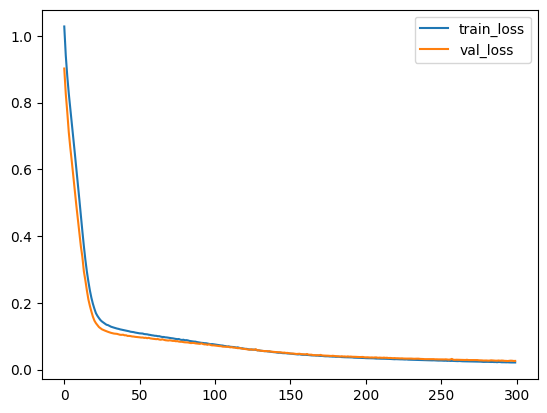

In [54]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

<h2>Evaluation metrics for each and every label</h2>

In [55]:
mae_dict_FFNN = {}
mse_dict_FFNN = {}
for column in predictions_FFNN_df.columns:
    mae = mean_absolute_error(y_test[column], predictions_FFNN_df[column])
    mse = mean_squared_error(y_test[column], predictions_FFNN_df[column])
    mae_dict_FFNN[column] = mae
    mse_dict_FFNN[column] = mse

print("MAE for each column:")
for column, mae in mae_dict_FFNN.items():
    print(f"{column}: {mae}")

print("\nMSE for each column:")
for column, mse in mse_dict_FFNN.items():
    print(f"{column}: {mse}")

MAE for each column:
BONN/flow.bc: 8.193768527692379
KOELN/flow.bc: 5.069035125765826
DUESS/flow.bc: 5.673179221470804
DUISB/flow.bc: 6.454866626908443
WESEL/flow.bc: 6.139150902532369
REES/flow.bc: 6.5625134476801845
EMMER/flow.bc: 5.224783870576886

MSE for each column:
BONN/flow.bc: 129.72960824972685
KOELN/flow.bc: 53.865999958583
DUESS/flow.bc: 61.99446096422639
DUISB/flow.bc: 81.83856916003243
WESEL/flow.bc: 82.7113026894171
REES/flow.bc: 87.43872401738746
EMMER/flow.bc: 63.92534477982936


<h2>Output visualization</h2>

In [60]:
y_test_array = np.array(y_test)
for i in range(0,len(df_output)):
    data= {
        'Date': df_output.index[-len(predictions):],
        'Predictions': predictions_rescaled[:, i],
        'Simulated MBC': np.array(y_test)[:, i]
        }

    df_plot = pd.DataFrame(data)

    fig = px.scatter(df_plot, x='Date', y=['Predictions', 'Simulated MBC'],
                    labels={'value': 'Mass balance correction (m³/s)'},
                    title='Predictions vs Actual for ' + df_output.columns[i],
                    color_discrete_sequence=['blue', 'orange'])
    fig.update_traces(marker={'size': 2},
                    mode='lines+markers')
    fig.update_layout(width=900, height=600)
    fig.show()
    # filepath=r'C:\Users\sujan.maharjan\Desktop\KISTERS\figures\MV_FFNN_'+df_output.columns[i][:3]+'.html'
    # fig.write_html(filepath)
    #filepath=r'C:\Users\sujan.maharjan\Desktop\KISTERS\Outputs_for_WSV\MIMO_FFNN_discharge_'+df_output.columns[i][:3]+'.csv'
    

IndexError: index 7 is out of bounds for axis 1 with size 7

<h2>Validation </h2>

In [39]:
predictions_val = model.predict(X_val_scaled)
predictions_rescaled_val = scaler_y.inverse_transform(predictions_val)

mae_FFNN_val=mean_absolute_error(y_val, predictions_rescaled_val)
mse_FFNN_val=mean_squared_error(y_val, predictions_rescaled_val)

predictions_FFNN_df_val=pd.DataFrame(predictions_rescaled_val)
predictions_FFNN_df_val.columns=y_val.columns

mae_FFNN_val, mse_FFNN_val

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


(7.65907338894482, 113.08981348781856)

<h2>Evaluation metrics for each and every label</h2>

In [40]:
mae_dict_FFNN_val = {}
mse_dict_FFNN_val = {}
for column in predictions_FFNN_df_val.columns:
    mae_val = mean_absolute_error(y_val[column], predictions_FFNN_df_val[column])
    mse_val = mean_squared_error(y_val[column], predictions_FFNN_df_val[column])
    mae_dict_FFNN_val[column] = mae_val
    mse_dict_FFNN_val[column] = mse_val

print("MAE for each column:")
for column, mae_val in mae_dict_FFNN_val.items():
    print(f"{column}: {mae_val}")

print("\nMSE for each column:")
for column, mse_val in mse_dict_FFNN_val.items():
    print(f"{column}: {mse_val}")


MAE for each column:
BONN/flow.bc: 8.163408944856558
KOELN/flow.bc: 6.243612825809444
DUESS/flow.bc: 5.650385323016207
DUISB/flow.bc: 7.963413470989613
WESEL/flow.bc: 10.375813743170818
REES/flow.bc: 6.532527568236075
EMMER/flow.bc: 8.684351846535023

MSE for each column:
BONN/flow.bc: 137.95154926481314
KOELN/flow.bc: 72.69794596655763
DUESS/flow.bc: 53.9929733424771
DUISB/flow.bc: 107.11974878682283
WESEL/flow.bc: 205.09028053594326
REES/flow.bc: 72.28151860881614
EMMER/flow.bc: 142.49467790930046


<h2>Output visualization</h2>

In [41]:
for i in range(0,len(df_output)):
    data= {
        'Date': y_val.index,
        'MIMO FFNN Discharge': predictions_rescaled_val[:, i],
        'DA': np.array(y_val)[:, i]
        }

    df_plot_val = pd.DataFrame(data)

    fig = px.scatter(df_plot_val, x='Date', y=['MIMO FFNN Discharge', 'DA'],
                    labels={'value': 'Mass balance correction (m³/s)'},
                    title='MIMO FFNN all Discharge input for ' + df_output.columns[i],
                    color_discrete_sequence=['blue', 'orange'])
    fig.update_traces(marker={'size': 2},
                    mode='lines+markers')
    
    fig.update_layout(width=900, height=600,
                      legend={
                          'x': 0.75,  # x position
                          'y': 0.01,  # y position
                          'bgcolor': 'rgba(255, 255, 255, 0.5)',  # semi-transparent background
                          'bordercolor': 'Black',
                          'borderwidth': 1
                      })
    fig.show()
    # filepath=r'C:\Users\sujan.maharjan\Desktop\KISTERS\figures\MV_FFNN_'+df_output.columns[i][:3]+'.html'
    # fig.write_html(filepath)

IndexError: index 7 is out of bounds for axis 1 with size 7

<h1>LSTM model</h1>

In [682]:
scaler_x=MinMaxScaler(feature_range=(-1,1))
scaler_y=MinMaxScaler(feature_range=(-1,1))
X_train_scaled_np = scaler_x.fit_transform(X_train)
X_test_scaled_np  = scaler_x.transform(X_test)

y_train_scaled_np  = scaler_y.fit_transform(y_train)
y_test_scaled_np  = scaler_y.transform(y_test)

X_train_scaled_np.shape, y_train_scaled_np.shape, X_test_scaled_np.shape, y_test_scaled_np.shape
#X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled

((2446, 15), (2446, 7), (1206, 15), (1206, 7))

<h2>Model Initialization</h2>

In [687]:
model_lstm = Sequential([
    LSTM(200, input_shape=(X_train_scaled_np.shape[1], 1), activation='relu', return_sequences=True),
    LSTM(200, activation='relu', return_sequences=False),
    Dense(y_train_scaled_np.shape[1])  # Output layer
])

c:\Projects\WSV\kisters.water.rto_ipopt\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



<h2>Model compilation</h2>

In [688]:
#model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.compile(loss= MeanSquaredError(),optimizer= Adam(learning_rate=0.001),metrics=[RootMeanSquaredError()])

<h2>Model fit</h2>

In [689]:
history_lstm = model_lstm.fit(X_train_scaled_np.reshape(X_train_scaled.shape[0], X_train_scaled_np.shape[1], 1),
                               y_train_scaled_np,
                               epochs=40,
                               validation_split=0.5)

Epoch 1/40


39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.0586 - root_mean_squared_error: 0.2387 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0980
Epoch 2/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0087 - root_mean_squared_error: 0.0929 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829
Epoch 3/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0817
Epoch 4/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739
Epoch 5/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0735
Epoch 6/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721
Epoch 7/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0058 - r

<h2>Model Evaluation</h2>

In [690]:
predictions_lstm = model_lstm.predict(X_test_scaled_np.reshape(X_test_scaled_np.shape[0], X_test_scaled_np.shape[1], 1))
predictions_rescaled_lstm = scaler_y.inverse_transform(predictions_lstm)
mae_lstm = mean_absolute_error(y_test, predictions_rescaled_lstm)

mae_lstm=mean_absolute_error(y_test, predictions_rescaled_lstm)
mse_lstm=mean_squared_error(y_test, predictions_rescaled_lstm)
mae_lstm, mse_lstm

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


(15.506977426315727, 533.0224895397197)

<h2>Output visualisation</h2>

In [ ]:
plt.figure(figsize=(60, 6))
plt.plot(df_output.index[-len(predictions_lstm):], np.array(y_test)[:, 0], label='Actual')
plt.plot(df_output.index[-len(predictions_lstm):], predictions_rescaled_lstm[:, 0], label='Predictions (LSTM)')
plt.xlabel('Date')
plt.ylabel('Discharge difference')
plt.legend()
plt.show()